<a href="https://colab.research.google.com/github/ozguozkan/DI725_Assign2/blob/main/DI725_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connecting to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

importing necessary libs

In [ ]:
import os
import json
from __future__ import annotations
import torch
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import random_split
import wandb
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

wandb login

In [ ]:
!pip install -q wandb

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ozgukan to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

getting the detr_resnet50 model

In [ ]:
!pip install -q transformers

from transformers import DetrForObjectDetection, DetrImageProcessor

my paths in colab

In [ ]:
path = '/content/drive/MyDrive/auair2019'
img_path = os.path.join(path, 'images')
annot_path = os.path.join(path, 'annotations.json')

reading the annotations

In [ ]:
with open(annot_path, 'r') as f:
  annotations = json.load(f)

print(json.dumps(annotations['annotations'][0], indent=2)) #seeing the first images info


{
  "image_name": "frame_20190829091111_x_0001973.jpg",
  "image_width:": 1920.0,
  "image_height": 1080.0,
  "platform": "Parrot Bebop 2",
  "time": {
    "year": 2019,
    "month": 8,
    "day": 29,
    "hour": 9,
    "min": 11,
    "sec": 11,
    "ms": 394400.0
  },
  "longtitude": 10.18798203255313,
  "latitude": 56.20630134795274,
  "altitude": 19921.6,
  "linear_x": 0.03130074199289083,
  "linear_y": 0.028357808757573367,
  "linear_z": 0.0744575835764408,
  "angle_phi": -0.06713105738162994,
  "angle_theta": 0.06894744634628296,
  "angle_psi": 1.1161083340644837,
  "bbox": [
    {
      "top": 163,
      "left": 1098,
      "height": 185,
      "width": 420,
      "class": 1
    },
    {
      "top": 421,
      "left": 1128,
      "height": 176,
      "width": 393,
      "class": 1
    },
    {
      "top": 927,
      "left": 1703,
      "height": 153,
      "width": 183,
      "class": 0
    }
  ]
}


In [ ]:
print("Toplam annotation sayısı:", len(dataset.annotations))

Toplam annotation sayısı: 32823


i need to fix image_width: problem

i need to change the annotaiton format into  (x min, y min, x max, y max) and i ned the match each annotation with its image

In [ ]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

class_mapping = {
    1: 0,  # human
    2: 1,  # car
    3: 2,  # truck
    4: 3,  # van
    5: 4,  # motorbike
    6: 5,  # bicycle
    7: 6,  # bus
    8: 7   # trailer
}
class auairdata(Dataset):
    def __init__(self, annot_path, img_dir, image_processor):
        with open(annot_path, 'r') as f:
            all_data = json.load(f)
            self.annotations = all_data["annotations"]

        self.img_dir = img_dir
        self.image_processor = image_processor
        self.converted_annotations = []

        self.image_name_to_id = {
            name: idx for idx, name in enumerate(
                sorted(set([ann["image_name"] for ann in self.annotations]))
            )
        }



    #to make my data compatible with the hw i change the variables
    #pytorch expects the data as x_min, y_max etc.
        for annot in self.annotations:
            image_name = annot["image_name"]
            image_id = self.image_name_to_id[image_name]

            for bbox in annot["bbox"]:
                x = bbox["left"]
                y = bbox["top"]
                w = bbox["width"]
                h = bbox["height"]
                original_cls = bbox["class"]

                if original_cls not in class_mapping:
                    continue

                cls = class_mapping[original_cls]

                self.converted_annotations.append({
                    "image_id": image_id,
                    "image_name": image_name,
                    "bbox": [x, y, w, h],
                    "category_id": cls,
                    "area": w * h,
                    "iscrowd": 0
                })

        self.image_names = [ann["image_name"] for ann in self.annotations]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annot = self.annotations[idx]
        img_path = os.path.join(self.img_dir, annot["image_name"])

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"missing image: {annot['image_name']}")
            return self.__getitem__((idx + 1) % len(self))  # atla

        image_id = self.image_name_to_id[annot["image_name"]]
        coco_labels = [
            ann for ann in self.converted_annotations
            if ann["image_id"] == image_id
        ]

        mytargets = {
            "image_id": image_id,
            "annotations": coco_labels
        }

        encode = self.image_processor(image, annotations=mytargets, return_tensors="pt")

        return {
            "pixel_values": encode["pixel_values"].squeeze(0),
            "labels": encode["labels"][0]
        }

def collate_fn(batch):
    batch = [b for b in batch if b is not None]  # eksikleri ayıkla
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]
    return {
        "pixel_values": torch.stack(pixel_values),
        "labels": labels
    }
dataset = auairdata(
    annot_path=annot_path,
    img_dir=img_path,
    image_processor=image_processor
)

# DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

save_path = os.path.join(path, "converted_annotations_with_names.json")
with open(save_path, "w") as f:
    json.dump({"annotations": dataset.converted_annotations}, f, indent=2)

print(f"coco format saved: {save_path}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


coco format saved: /content/drive/MyDrive/auair2019/converted_annotations_with_names.json


In [ ]:
class CocoStyleDataset(Dataset):
    def __init__(self, annotation_path, img_dir, image_processor, transform=None):
        with open(annotation_path, 'r') as f:
            all_data = json.load(f)
            self.annotations = all_data["annotations"]

        self.img_dir = img_dir
        self.image_processor = image_processor
        self.transform = transform

        # if there is image name group them
        self.image_to_annots = {}
        for ann in self.annotations:
            img_name = ann["image_name"]
            self.image_to_annots.setdefault(img_name, []).append(ann)

        self.image_names = sorted(self.image_to_annots.keys())

        self.image_name_to_id = {
            name: idx for idx, name in enumerate(self.image_names)
        }

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        annots = self.image_to_annots[image_name]
        image_id = self.image_name_to_id[image_name]

        mytargets = {
            "image_id": image_id,
            "annotations": annots
        }

        encode = self.image_processor(image, annotations=mytargets, return_tensors="pt")

        return {
            "pixel_values": encode["pixel_values"].squeeze(0),
            "labels": encode["labels"][0]
        }


In [ ]:
dataset = CocoStyleDataset(
    annotation_path=os.path.join(path, "converted_annotations_with_names.json"),
    img_dir=os.path.join(path, "images"),
    image_processor=image_processor
)

In [ ]:
import json

with open('/content/drive/MyDrive/auair2019/converted_annotations_with_names.json', 'r') as f:
    data = json.load(f)

category_ids = [ann["category_id"] for ann in data["annotations"]]
print("Eşsiz sınıf ID'leri:", sorted(set(category_ids)))
print("Toplam sınıf sayısı:", len(set(category_ids)))


Eşsiz sınıf ID'leri: [0, 1, 2, 3, 4, 5, 6, 7]
Toplam sınıf sayısı: 8


In [ ]:
import random

sample_ann = random.choice(data["annotations"])
print(json.dumps(sample_ann, indent=2))

{
  "image_id": 19042,
  "bbox": [
    1207,
    237,
    206,
    144
  ],
  "category_id": 2,
  "area": 29664,
  "iscrowd": 0,
  "image_name": "frame_20190905112522_x_0001297.jpg"
}


checking how many classes are there in the auair datasaet

In [ ]:
with open('/content/drive/MyDrive/auair2019/annotations.json', 'r') as f:
    data = json.load(f)

annotations = data["annotations"]  # my annot list is here

class_ids = set()

for ann in annotations:
    for bbox in ann["bbox"]:
        class_ids.add(bbox["class"])

print(f"total class num: {len(class_ids)}")
print(f"classes: {sorted(class_ids)}")


total class num: 8
classes: [0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#as we seen before in auair dataset there are 8 classes and the backgorund so 9 classes
#i need to adjust the class number for the detr model
#the detr also wants tje background thats  why i add it

num_classes = 9

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=num_classes,  # class num
    ignore_mismatched_sizes=True
)

model.to(device)
model.train()

id2label = {
    0: "human",
    1: "car",
    2: "truck",
    3: "van",
    4: "motorbike",
    5: "bicycle",
    6: "bus",
    7: "trailer",
    8: "background"
}
label2id = {v: k for k, v in id2label.items()}

model.config.id2label = id2label
model.config.label2id = label2id

model.name_or_path = "detr-resnet-50-auair"

print("Model loaded and configed")


device: cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Model loaded and configed


splitting the dataset

In [ ]:
#%70 train, %15 val, %15 test
ful_len = len(dataset)
train_len = int(0.7*ful_len)
val_len = int(0.15*ful_len)
test_len = ful_len - train_len - val_len

print(f"train: {train_len}, val: {val_len}, test:{test_len}")

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

#i add num workers an pin memory bc 4 epochs lasted 11.30 hours
my_loader = {
    "batch_size": 16,
    "num_workers": 4,
    "pin_memory": True,
    "collate_fn": collate_fn
}

#DataLoaders
train_loader = DataLoader(train_dataset, shuffle=True, **my_loader)
# val_loader   = DataLoader(val_dataset,   shuffle=False, **my_loader)
val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn
)
test_loader  = DataLoader(test_dataset,  shuffle=False, **my_loader)

train: 22493, val: 4819, test:4821


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

[Epoch 1] Train Loss: 1.8933 | Val Loss: 1.5918
[Epoch 1] best model saved (val_loss: 1.5918)


[Epoch 2] Train Loss: 1.6608 | Val Loss: 1.5551
[Epoch 2] best model saved (val_loss: 1.5551)


[Epoch 3] Train Loss: 1.8649 | Val Loss: 1.9125


[Epoch 4] Train Loss: 2.5264 | Val Loss: 2.6386


[Epoch 5] Train Loss: 2.6275 | Val Loss: 2.3492


[Epoch 6] Train Loss: 2.8006 | Val Loss: 2.7593


[Epoch 7] Train Loss: 2.7162 | Val Loss: 2.4544


[Epoch 8] Train Loss: 2.4993 | Val Loss: 2.3217


[Epoch 9] Train Loss: 2.5423 | Val Loss: 2.4170


[Epoch 10] Train Loss: 2.5590 | Val Loss: 2.4385


[Epoch 11] Train Loss: 2.5822 | Val Loss: 2.4410


[Epoch 12] Train Loss: 2.5501 | Val Loss: 2.3980


[Epoch 13] Train Loss: 2.4339 | Val Loss: 2.2935


[Epoch 14] Train Loss: 2.4863 | Val Loss: 2.3278


[Epoch 15] Train Loss: 2.4402 | Val Loss: 2.3214
test loss: 2.4111


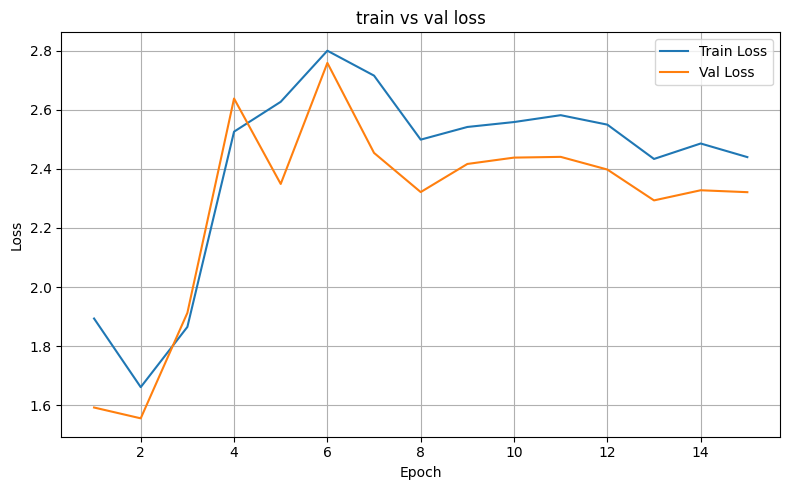

In [ ]:
wandb.init(project = "DI725-Assignment2", name = "detr-finetune", config = {
    "epochs": 15,
    "batch_size": 16,
    "lr": 5e-5
})


model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels = 9,
    ignore_mismatched_sizes = True).to(device)

id2label = {
    0: "human", 1: "car", 2: "truck", 3: "van",
    4: "motorbike", 5: "bicycle", 6: "bus", 7: "trailer", 8: "background"
}
label2id = {v: k for k, v in id2label.items()}
model.config.id2label = id2label
model.config.label2id = label2id

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

train_losses = []
val_losses = []
best_val_loss = float("inf")

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
      # val_bar = tqdm(dataloader, desc="Evaluating", leave=False)
      # for batch in val_bar:
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = [
                {k: v.to(device).float() if k == "boxes" else v.to(device)
                 for k, v in l.items()} for l in batch["labels"]
            ]
            outputs = model(pixel_values=pixel_values, labels=labels)
            total_loss += outputs.loss.item()
    return total_loss / len(dataloader)

#train
for epoch in range(wandb.config["epochs"]):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{wandb.config['epochs']}", leave=False)

    for batch in train_bar:
        pixel_values = batch["pixel_values"].to(device)
        labels = [
            {k: v.to(device).float() if k == "boxes" else v.to(device)
             for k, v in l.items()} for l in batch["labels"]
        ]

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix({"Loss": loss.item()})

    train_loss = running_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#saving the best model
    # En iyi modeli kaydet
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_detr_model.pth")
        print(f"[Epoch {epoch+1}] best model saved (val_loss: {val_loss:.4f})")
        wandb.save("best_detr_model.pth")

#evaluating test performance
test_loss = evaluate(model, test_loader)
wandb.log({"test_loss": test_loss})
print(f"test loss: {test_loss:.4f}")

#plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("train vs val loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

wandb.log({
    "train_val_loss_curve": wandb.plot.line_series(
        xs=list(range(1, len(train_losses)+1)),
        ys=[train_losses, val_losses],
        keys=["Train", "Val"],
        title="Loss Over Epochs",
        xname="Epoch"
    )
})

In [ ]:
import json
import os

#load file
with open(os.path.join(path, "converted_annotations_with_names.json"), "r") as f:
    data = json.load(f)

annotations = data["annotations"]

#make coco format
images = []
categories = [
    {"id": 0, "name": "human"},
    {"id": 1, "name": "car"},
    {"id": 2, "name": "truck"},
    {"id": 3, "name": "van"},
    {"id": 4, "name": "motorbike"},
    {"id": 5, "name": "bicycle"},
    {"id": 6, "name": "bus"},
    {"id": 7, "name": "trailer"},
    {"id": 8, "name": "background"}
]

# image_name → id match
image_id_set = {}
image_id_counter = 0
annotation_id = 0

for ann in annotations:
    img_name = ann["image_name"]
    if img_name not in image_id_set:
        image_id_set[img_name] = image_id_counter
        images.append({
            "id": image_id_counter,
            "file_name": img_name
        })
        image_id_counter += 1

#add idto the annots
for ann in annotations:
    ann["id"] = annotation_id
    ann["image_id"] = image_id_set[ann["image_name"]]
    annotation_id += 1

#new coco format file
coco_format = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

coco_ready_path = os.path.join(path, "converted_annotations_coco_ready.json") #save as json
with open(coco_ready_path, "w") as f:
    json.dump(coco_format, f, indent=2)

print(f"coco format ready: {coco_ready_path}")


In [ ]:
from tqdm import tqdm
from transformers import DetrImageProcessor
from torchvision.ops import box_convert
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import json
import os

model.eval()

#sum all
results = []
image_id = 0

for batch in tqdm(test_loader, desc="Running inference"):
    pixel_values = batch["pixel_values"].to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    # output format
    target_sizes = [v.shape[-2:] for v in batch["pixel_values"]]
    results_batch = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)

    for i, result in enumerate(results_batch):
        boxes = result["boxes"]
        scores = result["scores"]
        labels = result["labels"]

        boxes = box_convert(boxes, in_fmt="xyxy", out_fmt="xywh") #transforming into coco format

        for box, score, label in zip(boxes, scores, labels):
            results.append({
                "image_id": image_id,
                "category_id": label.item(),
                "bbox": box.tolist(),
                "score": score.item()
            })
        image_id += 1

pred_path = "detr_predictions.json" #save as json
with open(pred_path, "w") as f:
    json.dump(results, f, indent=2)
print(f"Predictions saved to {pred_path}")

gt_path = os.path.join(path, "converted_annotations_coco_ready.json")
coco_gt = COCO(gt_path)

coco_dt = coco_gt.loadRes(pred_path)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Running inference: 100%|██████████| 302/302 [02:01<00:00,  2.48it/s]


Predictions saved to detr_predictions.json
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.78s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.97s).
Accumulating evaluation results...
DONE (t=2.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (